In [1]:
# def generate_arrays_from_file(path):
#     while 1:
#         f = open(path)
#         for line in f:
#             # create numpy arrays of input data
#             # and labels, from each line in the file
#             x = np.array(convert_to_ela_image(line.strip(), 90).resize((128, 128))).flatten()
                
#             y = np.array([0, 0])
#             if line.split('_')[0] == 'Au':
#                 y = np.array([0, 1])
#             else:
#                 y = np.array([1, 0])
#             x = x / 255.0`
            
#             x = x.reshape(-1, 128, 128, 3)
            
#             print(line.strip())
#             print("Berhasil")
#             print(y + '\n')
            
#             yield (x, y)
#         f.close()

In [ ]:
# Fit Model Here
# history = model.fit_generator(
#         train_generator,
#         steps_per_epoch=23,
#         epochs=epochs,
#         validation_data=validation_generator,
#         validation_steps=5)
# history = model.fit_generator(generate_arrays_from_file('datasets/file_path.txt'),
#         samples_per_epoch=1500, nb_epoch=10)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [3]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt

In [4]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path)]

In [53]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    os.remove(resaved_filename)
    return ela_im

In [54]:
filenames = get_imlist('datasets/validation/fake/')

In [55]:
len(filenames)

500

In [56]:
df_train = pd.read_csv('datasets/dataset.csv')
df_train

,filename,label
0,datasets/train/real/Au_sec_30282.jpg,0
1,datasets/train/real/Au_sec_00098.jpg,0
2,datasets/train/real/Au_pla_00032.jpg,0
3,datasets/train/real/Au_nat_30651.jpg,0
4,datasets/train/real/Au_pla_30745.jpg,0
5,datasets/train/real/Au_cha_30678.jpg,0
6,datasets/train/real/Au_arc_30360.jpg,0
7,datasets/train/real/Au_arc_30061.jpg,0
8,datasets/train/real/Au_pla_30033.jpg,0
9,datasets/train/real/Au_ind_30157.jpg,0


In [57]:
df_validation = pd.read_csv('datasets/test_dataset.csv')
df_validation

,filename,label
0,datasets/validation/real/Au_ani_30047.jpg,0
1,datasets/validation/real/Au_ani_30242.jpg,0
2,datasets/validation/real/Au_ani_30265.jpg,0
3,datasets/validation/real/Au_ani_30281.jpg,0
4,datasets/validation/real/Au_ani_10106.jpg,0
5,datasets/validation/real/Au_ani_20029.jpg,0
6,datasets/validation/real/Au_ani_10206.jpg,0
7,datasets/validation/real/Au_ani_30206.jpg,0
8,datasets/validation/real/Au_ani_30049.jpg,0
9,datasets/validation/real/Au_ani_30165.jpg,0


In [58]:
class CustomGenerator(Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = []
        for file_name in batch_x:
            x.append(array(convert_to_ela_image(file_name, 90).resize((128, 128))).flatten() / 255.0)
        x = np.array(x)
        x = x.reshape(-1, 128, 128, 3)
        
        y = to_categorical(batch_y, 2)
        return x, y

# Model

In [59]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [60]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [61]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [62]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [63]:
num_epochs = 50
batch_size = 500
num_training_samples = df_train.shape[0]
num_validation_samples = df_validation.shape[0]

In [64]:
my_training_batch_generator = CustomGenerator(df_train['filename'], df_train['label'], batch_size)
my_validation_batch_generator = CustomGenerator(df_validation['filename'], df_validation['label'], batch_size)

In [65]:
history = model.fit_generator(generator=my_training_batch_generator,
                    steps_per_epoch=(num_training_samples // batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=my_validation_batch_generator,
                    validation_steps=(num_validation_samples // batch_size),
                    use_multiprocessing=True,
                    workers=1,
                    max_queue_size=32)


Epoch 1/50


/home/holy/anaconda3/envs/cv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))
/home/holy/anaconda3/envs/cv/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag))


ResourceExhaustedError: OOM when allocating tensor with shape[500,32,124,124] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_11/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_3/RMSprop/gradients/conv2d_11/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_11/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics_5/acc/Mean/_291 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_669_metrics_5/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


NameError: name 'history' is not defined

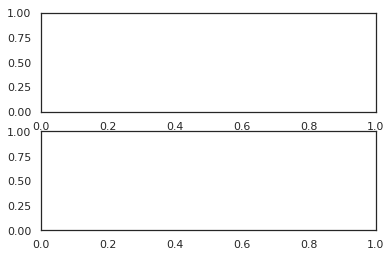

In [172]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

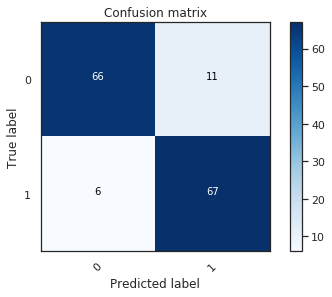

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))